<a href="https://colab.research.google.com/github/mertcan-basut/nlp/blob/main/classification_and_vector_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature Extraction with Frequencies

- **Preprocessing**
  - Eliminate handles and URLs
  - Tokenize the string into words
  - Remove stop words (and, is, a, on, etc.) and punctuation
  - Stemming
  - Convert all words to lower case
- Create vocabulary from corpus
- **Feature extraction**
  - Create a dictionary to map the word, and the class it appeared in
  - `X = [bias, sum of (+) freqs., sum of (-) freqs.]`
  - `Y = positive (1) or negative (0)`

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import random

import re
import string

import nltk
nltk.download("twitter_samples")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
positive_tweets = nltk.corpus.twitter_samples.strings("positive_tweets.json")
negative_tweets = nltk.corpus.twitter_samples.strings("negative_tweets.json")
data = pd.DataFrame(data={"tweet": positive_tweets + negative_tweets, "sentiment": [1]*len(positive_tweets) + [0]*len(negative_tweets)})
data.head()

,tweet,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1


In [ ]:
stopwords_english = stopwords.words('english')
punctuations = string.punctuation

def pre_process(tweet):
  tweet_stripped = re.sub(r'^RT[\s]+', '', tweet) # remove old style retweet text "RT"
  tweet_stripped = re.sub(r'https?://[^\s\n\r]+', '', tweet_stripped) # remove hyperlinks
  tweet_stripped = re.sub(r'#', '', tweet_stripped) # remove hashtags

  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tokens = tokenizer.tokenize(tweet_stripped)

  tokens_stripped = [word for word in tokens if word not in stopwords_english and word not in punctuations]

  stemmer = PorterStemmer()
  stems = [stemmer.stem(word) for word in tokens_stripped]

  return stems

data["tweet_processed"] = data["tweet"].apply(pre_process)
data.head()

,tweet,sentiment,tweet_processed
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,"[followfriday, top, engag, member, commun, wee..."
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,"[hey, jame, odd, :/, pleas, call, contact, cen..."
2,@DespiteOfficial we had a listen last night :)...,1,"[listen, last, night, :), bleed, amaz, track, ..."
3,@97sides CONGRATS :),1,"[congrat, :)]"
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,..."


In [ ]:
vocabulary = {}
for index, row in data.iterrows():
  tweet = row["tweet_processed"]
  sentiment = row["sentiment"]
  for word in tweet:
    if word not in vocabulary:
      vocabulary[word] = [0, 0] # create vocabulary
    if sentiment == 1:
      vocabulary[word][0] += 1 # positive
    elif sentiment == 0:
      vocabulary[word][1] += 1 # negative

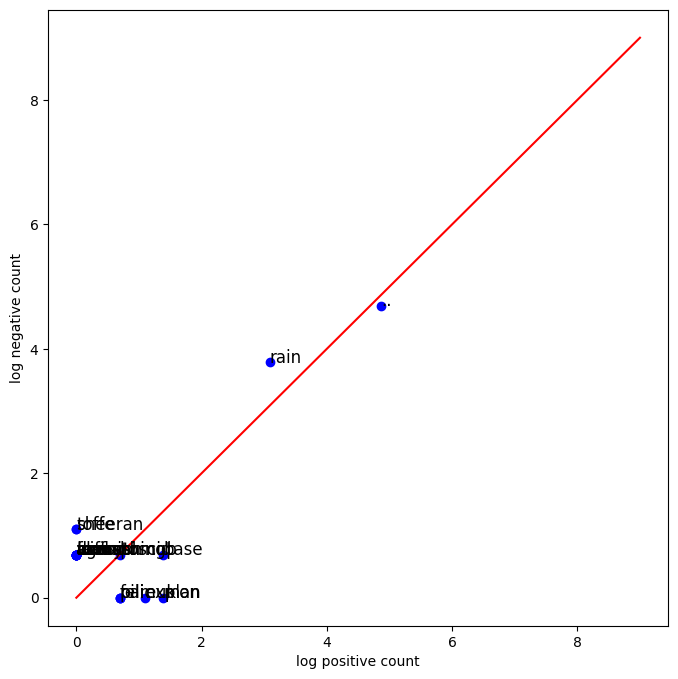

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for word, freqs in random.sample(list(vocabulary.items()), 20):
  x = np.log(freqs[0] + 1)
  y = np.log(freqs[1] + 1)
  ax.scatter(x, y, c='blue')
  ax.annotate(word, (x, y), fontsize=12)
ax.plot([0, 9], [0, 9], color='red')
plt.xlabel("log positive count")
plt.ylabel("log negative count")
plt.show()

In [ ]:
def frequency(tweet_processed):
  positive_freq = 0
  negative_freq = 0
  for word in tweet_processed:
    positive_freq += vocabulary[word][0]
    negative_freq += vocabulary[word][1]
  return positive_freq, negative_freq

data[["positive_freq", "negative_freq"]] = data.apply(lambda x: frequency(x["tweet_processed"]), axis=1, result_type='expand')
data.head()

,tweet,sentiment,tweet_processed,positive_freq,negative_freq
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,"[followfriday, top, engag, member, commun, wee...",3887,72
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,"[hey, jame, odd, :/, pleas, call, contact, cen...",4613,518
2,@DespiteOfficial we had a listen last night :)...,1,"[listen, last, night, :), bleed, amaz, track, ...",3883,161
3,@97sides CONGRATS :),1,"[congrat, :)]",3712,4
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,...",4038,281


In [ ]:
X = data[["positive_freq", "negative_freq"]]
y = data["sentiment"]

model_lr = LogisticRegression()
model_lr.fit(X, y)

print("accuracy: ", model_lr.score(X, y))
print("cross-entropy loss: ", log_loss(y, model_lr.predict_proba(X)))

accuracy:  0.9933
cross-entropy loss:  0.023936908038691654
